In [1]:
# basics
import os
import re
import string
import numpy as np
import pandas as pd
from collections import Counter
from random import sample
from pathlib import Path

# For cleaning the time object
from datetime import datetime
import pytz

# For visualizations
from matplotlib import pyplot as plt

# For spatial analysis
import geopandas as gpd

# For sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# A package for preprocessing(officially used in SemEval NLP competition)
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import paddlehub as hub

# 0. Prepare the paths, data, and more

In [2]:
class DataPrepare(object):
    
    project_path = r'D:\Projects\count_tweet'  # Specify a project directory
    # Get all the punctuations\
    punctuations_all = string.punctuation + '。，﹑？！：；“”（）《》•……【】'
    
    def __init__(self, city_name, timezone, tweet_path):
        """
        Prepare the city name, timezone, and path for the tweet data
        :param city_name: the name of a city
        :param timezone: the timezone of a city
        :param tweet_path: the path saving the tweet csv data
        """
        self.city_name = city_name
        self.timezone = timezone
        self.tweet_path = tweet_path
        
    def __str__(self):
        """
        Print the basic information about the processed city
        """
        total_size = DataPrepare.filesize(self.get_size())
        string = 'city: {}\ntimezone: {}\ndata path: {}\ntotal size: {}'.format(
            self.city_name, self.timezone, self.tweet_path, total_size)
        return string
    
    def get_size(self) -> int:
        """
        Get the size of all files in one directory in bytes
        """
        return sum(p.stat().st_size for p in Path(self.tweet_path).rglob('*'))
    
    def get_combined_tweets(self) -> pd.DataFrame:
        """
        Get the combined tweet dataframe
        """
        dataframe_list = []
        for file in os.listdir(self.tweet_path):
            dataframe = pd.read_csv(os.path.join(self.tweet_path, file), encoding='utf-8', index_col=0)
            dataframe_list.append(dataframe)
        concat_data = pd.concat(dataframe_list, axis=0).reset_index(drop = True)
        DataPrepare.data_overview(concat_data)
        return concat_data
    
    @staticmethod
    def filesize(size: int) -> str:
        for unit in ("B", "K", "M", "G"):
            if size < 1024:
                break
            size /= 1024
        return f"{size:.1f}{unit}"
    
    @staticmethod
    def data_overview(dataframe: pd.DataFrame):
        assert 'user_id_str' in dataframe, "The dataframe should contain user id column"
        assert 'id_str' in dataframe, "The dataframe should contain tweet id column"
        tweet_num = len(set(dataframe['id_str']))
        user_num = len(set(dataframe['user_id_str']))
        print('# of Users: {}; # of Tweets: {}'.format(user_num, tweet_num))

In [3]:
HK_city = DataPrepare(city_name='Hong Kong', timezone=pytz.timezone('Asia/Shanghai'), 
                      tweet_path=os.path.join(DataPrepare.project_path, 'hk_tweets_2021'))

In [4]:
print(HK_city)

city: Hong Kong
timezone: Asia/Shanghai
data path: D:\Projects\count_tweet\hk_tweets_2021
total size: 26.7M


In [5]:
# load the sentiment analysis module
senta = hub.Module(name='senta_bilstm')

[2021-10-06 14:59:33,389] [    INFO] - Installing senta_bilstm module
[2021-10-06 14:59:33,566] [    INFO] - Module senta_bilstm already installed in C:\Users\Bright1993\.paddlehub\modules\senta_bilstm


# 1. Data Description

## 1.1 Column Description

Load a random file...

In [6]:
one_sample_file = pd.read_csv(os.path.join(HK_city.tweet_path, 'tweets_HongKong_202108251800.csv'), index_col=0, encoding='utf-8')

Screenshot of the studied dataframe...

In [7]:
one_sample_file

,text,retweet_count,favorite_count,favorited,truncated,id_str,in_reply_to_screen_name,source,retweeted,created_at,...,place_type,full_name,place_name,place_id,place_lat,place_lon,lat,lon,expanded_url,url
1,粉丝已清。从头再来 https://t.co/bldzOjcoKs,0,0,False,False,1430454946835492864,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,Wed Aug 25 09:00:10 +0000 2021,...,NaN,"Guangdong, People's Republic of China",Guangdong,00059b04495a7e37,22.869936,113.419725,NaN,NaN,NaN,NaN
2,何だかご無沙汰 https://t.co/0qXJrY4zfS,0,0,False,False,1430455316517253128,NaN,"<a href=""http://twitter.com/download/android"" ...",False,Wed Aug 25 09:01:38 +0000 2021,...,NaN,"Central & Western District, Hong Kong",Central & Western District,011a1d1e753ec5a8,22.276870,114.139883,NaN,NaN,NaN,NaN
3,Επιτέλους μετά από 13 μέρες φεύγουμε...\nΧονγκ...,0,0,False,False,1430455431843962884,NaN,"<a href=""http://twitter.com/download/android"" ...",False,Wed Aug 25 09:02:06 +0000 2021,...,NaN,People's Republic of China,People's Republic of China,4797714c95971ac1,35.808031,104.137242,NaN,NaN,NaN,NaN
4,体力温存のため一階席＆ズームて撮影\n\n#遊び疲れた無職 https://t.co/B4P...,0,0,False,False,1430455509811826691,NaN,"<a href=""http://twitter.com/download/android"" ...",False,Wed Aug 25 09:02:24 +0000 2021,...,NaN,"Central & Western District, Hong Kong",Central & Western District,011a1d1e753ec5a8,22.276870,114.139883,NaN,NaN,NaN,NaN
5,@jaybnow_hr Yez lets go bestie #fume_somoD1,0,0,False,False,1430455550530121732,jaybnow_hr,"<a href=""http://twitter.com/download/iphone"" r...",False,Wed Aug 25 09:02:34 +0000 2021,...,NaN,"Eastern District, Hong Kong",Eastern District,01f975a94dcb980c,22.272807,114.220734,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,开始了 #大学生 #广州 https://t.co/cgZdUhCewu,0,0,False,False,1430468844896669700,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,Wed Aug 25 09:55:24 +0000 2021,...,NaN,"Guangdong, People's Republic of China",Guangdong,00059b04495a7e37,22.869936,113.419725,NaN,NaN,NaN,NaN
139,按照你现在还在上学的这个年龄来说，如果你已经谈了好几个而且都无疾而终，你应该先从自身找问题。...,0,0,False,True,1430469181703561224,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,Wed Aug 25 09:56:44 +0000 2021,...,NaN,"广东, 中华人民共和国",广东,00059b04495a7e37,22.869936,113.419725,NaN,NaN,https://twitter.com/i/web/status/1430469181703...,https://t.co/XSzCoYp9YO
140,这样的身材，爱了吗\n\n今天开课哦！ https://t.co/JxEUBFYikk,0,0,False,False,1430469576555302916,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,Wed Aug 25 09:58:18 +0000 2021,...,NaN,"Guangdong, People's Republic of China",Guangdong,00059b04495a7e37,22.869936,113.419725,NaN,NaN,NaN,NaN
141,This is how we start with autumn\n新买的李宁x 新上架的小...,0,0,False,False,1430469839554940931,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,Wed Aug 25 09:59:21 +0000 2021,...,NaN,Shenzhen (深圳),Shenzhen (深圳),0fbeaf5fb6d47000,22.543952,114.054565,NaN,NaN,NaN,NaN


Descriptions about some most used columns are given below. For more information, please check: [User object in Tweepy](https://www.geeksforgeeks.org/python-user-object-in-tweepy/)

- text: the tweet’s text content

- id_str: the tweet’s unique id

- user_id_str: the tweet user’s id

- created_at: the tweet’s posting time (in UTC timezone)

- lang: the language use of the posted tweet

- truncated: whether the tweet text is truncated or not

- in_reply_to_screen_name: the user name that this tweet "@" in tweet text

- in_reply_to_status_id_str: the tweet unque id that this tweet replies

- in_reply_to_user_id_str: the Twitter user id that thie tweet replies

- description: the user profile description

- user_created_at: the time that the user registered his or her account

- verified: the twitter account is verified or not. One account is verified if it is belong to celebrity, organization, etc.

- place_lat: the latitude of the place that the tweet is associated

- place_lon: the longitude of the place that the tweet is associated

- lat: the accurate latitude information that the social media user shared

- lon: the accurate longitude information that the social media user shared

Data types of each column

In [8]:
one_sample_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 1 to 142
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   text                       142 non-null    object 
 1   retweet_count              142 non-null    int64  
 2   favorite_count             142 non-null    int64  
 3   favorited                  142 non-null    bool   
 4   truncated                  142 non-null    bool   
 5   id_str                     142 non-null    int64  
 6   in_reply_to_screen_name    49 non-null     object 
 7   source                     142 non-null    object 
 8   retweeted                  142 non-null    bool   
 9   created_at                 142 non-null    object 
 10  in_reply_to_status_id_str  49 non-null     float64
 11  in_reply_to_user_id_str    49 non-null     float64
 12  lang                       142 non-null    object 
 13  listed_count               142 non-null    int64  

# 2. Basic Analysis

Here we present some basic analysis for the collected Twitter data:
1. Time operation
2. Text cleaning
3. Sentiment analysis

In [9]:
%%time
combined_tweets = HK_city.get_combined_tweets()

# of Users: 5802; # of Tweets: 36666
Wall time: 2.86 s


## 2.1 Time operation

Output the time information for each tweet...

In [10]:
def transform_string_time_to_datetime(time_string, target_time_zone, convert_utc_time=False):
    """
    Transform the string time to the datetime
    :param time_string: a time string
    :param target_time_zone: the target time zone
    :param convert_utc_time: whether transfer the datetime object to utc first. This is true when the
    time string is recorded as the UTC time
    :return:
    """
    datetime_object = datetime.strptime(time_string, '%a %b %d %H:%M:%S %z %Y')
    if convert_utc_time:  # If the time string is recorded in UTC time or not
        final_time_object = datetime_object.replace(tzinfo=pytz.utc).astimezone(target_time_zone)
    else:
        final_time_object = datetime_object.astimezone(target_time_zone)
    return final_time_object

def get_year_month_day_hour_weekday(tweet_dataframe: pd.DataFrame, time_colname: str):
    """
    Get the year, month, day, and hour information
    """
    tweet_dataframe_copy = tweet_dataframe.copy()
    tweet_dataframe_copy['year'] = tweet_dataframe_copy.apply(lambda row: row[time_colname].year, axis=1)
    tweet_dataframe_copy['month'] = tweet_dataframe_copy.apply(lambda row: row[time_colname].month, axis=1)
    tweet_dataframe_copy['day'] = tweet_dataframe_copy.apply(lambda row: row[time_colname].day, axis=1)
    tweet_dataframe_copy['hour'] = tweet_dataframe_copy.apply(lambda row: row[time_colname].hour, axis=1)
    # 0 is Monday and 6 is Sunday
    tweet_dataframe_copy['weekday'] = tweet_dataframe_copy.apply(lambda row: row[time_colname].weekday(), axis=1)
    return tweet_dataframe_copy

In [11]:
combined_tweets['hk_time'] = combined_tweets.apply(
    lambda row: transform_string_time_to_datetime(row['created_at'], HK_city.timezone), axis=1)

In [12]:
combined_tweets_with_time = get_year_month_day_hour_weekday(combined_tweets, time_colname='hk_time')

In [13]:
combined_tweets_with_time[['created_at', 'hk_time', 'year', 'month', 'day', 'hour', 'weekday']]

,created_at,hk_time,year,month,day,hour,weekday
0,Wed Aug 25 06:36:12 +0000 2021,2021-08-25 14:36:12+08:00,2021,8,25,14,2
1,Wed Aug 25 06:36:29 +0000 2021,2021-08-25 14:36:29+08:00,2021,8,25,14,2
2,Wed Aug 25 06:37:29 +0000 2021,2021-08-25 14:37:29+08:00,2021,8,25,14,2
3,Wed Aug 25 06:38:07 +0000 2021,2021-08-25 14:38:07+08:00,2021,8,25,14,2
4,Wed Aug 25 06:38:29 +0000 2021,2021-08-25 14:38:29+08:00,2021,8,25,14,2
...,...,...,...,...,...,...,...
36663,Tue Sep 07 06:56:58 +0000 2021,2021-09-07 14:56:58+08:00,2021,9,7,14,1
36664,Tue Sep 07 06:57:09 +0000 2021,2021-09-07 14:57:09+08:00,2021,9,7,14,1
36665,Tue Sep 07 06:57:53 +0000 2021,2021-09-07 14:57:53+08:00,2021,9,7,14,1
36666,Tue Sep 07 06:58:18 +0000 2021,2021-09-07 14:58:18+08:00,2021,9,7,14,1


## 2.2 Text Cleaning

For more information about the language type and corresponding code, please check:

[Language Code List](https://www.loc.gov/standards/iso639-2/php/code_list.php)

### 2.2.1 Cleaning the English tweets

Firstly, we extract and preprocess the English tweets.

In [14]:
en_tweets = combined_tweets_with_time.loc[combined_tweets_with_time['lang'] == 'en']

In [15]:
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used
    # for word segmentation
    segmenter="twitter",

    # corpus from which the word statistics are going to be used
    # for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

def preprocessing_for_english(text_preprocessor, raw_text):
    preprocessed_text = ' '.join(text_preprocessor.pre_process_doc(str(raw_text)))
    # remove punctuations
    result = re.sub('[{}]'.format(string.punctuation), '', preprocessed_text)
    result_without_url = re.sub('url', '', result)
    result_without_dots = re.sub(' … ', '', result_without_url)
    result_without_user = re.sub('user', '', result_without_dots)
    return result_without_user

d:\python37\lib\site-packages\ekphrasis\classes\tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


d:\python37\lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


In [16]:
en_tweets_copy = en_tweets.copy().reset_index(drop = True)
en_tweets_copy['cleaned_text'] = en_tweets_copy.apply(lambda row: preprocessing_for_english(text_processor, row['text']), axis=1)

In [17]:
en_tweets_copy[['text', 'cleaned_text']]

,text,cleaned_text
0,Blue polycarbonate solid sheet on production h...,blue polycarbonate solid sheet on production
1,"Before visiting @BYDCompany today, I mistakenl...",before visiting today i mistakenly thought t...
2,I'm at Foresoon in Hong Kong https://t.co/wUVG...,i am at foresoon in hong kong
3,I'm at Central Market in Central https://t.co/...,i am at central market in central
4,Our #PLC leaders work together with the IBDP c...,our hashtag plc hashtag leaders work together ...
...,...,...
10086,"Jimdoa Nail Drill Machine, we are in the Guang...",jimdoa nail drill machine we are in the guang...
10087,"@laurachese One of the many, many reasons I re...",one of the many many reasons i refuse to was...
10088,@owl_denouncer @Kongduino @taro_taylor Medical...,medical reasons but i don ’ t allcaps thin...
10089,@CarolineHirons It’s really quite shocking to ...,it ’ s really quite shocking to read comes a...


### 2.2.2 Cleaning the Chinese tweets

In [18]:
zh_tweets = combined_tweets_with_time.loc[combined_tweets_with_time['lang'] == 'zh']

In [19]:
def preprocessing_chinese(raw_tweet):
    """
    Preprocess the Chinese weibo
    :param raw_tweet: raw Chinese weibo string
    :param tokenization: whether we conduct the tokenization or not
    :param return_word_list: whether we return the word list or not
    :return:
    """
    # 0. Remove the urls
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)" \
            r"))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text_without_url = re.sub(regex, '', raw_tweet)

    # 1. Remove the @user patterns
    text_without_username1 = re.sub('@[\u4e00-\u9fa5a-zA-Z0-9_-]{4,30}', '', text_without_url)
    text_without_username2 = re.sub('@ [\u4e00-\u9fa5a-zA-Z0-9_-]{4,30}', '', text_without_username1)
    text_without_username3 = re.sub('\/\/@.*?:', '', text_without_username2)

    # 2. Don't consider the numbers & hashtags
    words_only = re.sub("[0-9]", "", text_without_username2)
    words_without_hashtag = re.sub("#", "", words_only)

    return words_without_hashtag

In [20]:
zh_tweets_copy = zh_tweets.copy()
zh_tweets_copy['cleaned_text'] = zh_tweets_copy.apply(lambda row: preprocessing_chinese(row['text']), axis=1)

In [53]:
zh_tweets_copy[['text', 'cleaned_text']].sample(3)

,text,cleaned_text
17032,我觉得做爱用粤语是真的很神奇\n来回切换语言更好玩哈哈哈哈哈\n我地广东人 净系得把口哈哈哈...,我觉得做爱用粤语是真的很神奇\n来回切换语言更好玩哈哈哈哈哈\n我地广东人 净系得把口哈哈哈哈
13416,分手了，但捨不得刪掉。怎麼辦😭😭😭 https://t.co/E1dWOP29XK,分手了，但捨不得刪掉。怎麼辦😭😭😭
30968,中国太大了 真的太大了 https://t.co/AFleMu51qc,中国太大了 真的太大了


## 2.3 Sentiment analysis

Here we conduct the sentiment analysis for the English tweets and Chinese tweets.

### 2.3.1 Sentiment Analysis of English Tweets

In [22]:
# Determine the sentiment of a tweet based on the percentage of being positive, neutral & negative
def sentiment_scores_based_on_percent(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
  
    # decide sentiment as positive, negative and neutral 
    positive_percent = sentiment_dict['pos']
    neutral_percent = sentiment_dict['neu']
    negative_percent = sentiment_dict['neg']
    
    if (positive_percent >= neutral_percent) and (positive_percent >= negative_percent):
        return 2 # positive
    elif (neutral_percent >= positive_percent) and (neutral_percent >= negative_percent):
        return 1 # neutral
    else:
        return 0 # negative
    
# Perform sentiment analysis based on the Vader compound score
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
      
#     print("Overall sentiment dictionary is : ", sentiment_dict) 
#     print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
#     print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
#     print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 
  
#     print("Sentence Overall Rated As", end = " ") 
  
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.05:  ## positive
        return 2
  
    elif sentiment_dict['compound'] <= - 0.05 :  ## negative
        return 0 
  
    else:   ## neutral
        return 1

In [23]:
%%time
en_tweets_copy['sent_vader_percent'] = en_tweets_copy.apply(lambda row: sentiment_scores_based_on_percent(row['cleaned_text']), axis=1)

Wall time: 1min 43s


In [24]:
%%time
en_tweets_copy['sent_vader_score'] = en_tweets_copy.apply(lambda row: sentiment_scores(row['cleaned_text']), axis=1)

Wall time: 1min 42s


In [25]:
en_tweets_copy[['text', 'cleaned_text', 'sent_vader_percent', 'sent_vader_score']].sample(20)

,text,cleaned_text,sent_vader_percent,sent_vader_score
2691,🍸 @ Dragonfly https://t.co/Yi2bqdYS4I,🍸 dragonfly,1,1
2766,AQI: 23. The dominant pollutant is PM2.5. (Thi...,allcaps aqi allcaps number the dominant poll...,1,2
2720,PIZZA SKATEBOARDS \n#pizzaskateboards #evergr...,allcaps pizza skateboards allcaps hashtag pizz...,1,1
7779,@nathanlimyu Probably 🤣,probably 🤣,1,2
1237,"Hang on tight, little bear girl @ Kowloon, Hon...",hang on tight little bear girl kowloon hong...,1,1
5503,@ALDubFTnQT @wengcookie @elaineRequina2x @Glia...,lend hashtag aldu bat...,1,2
3912,"@Squadron People in China are super social, In...",people in china are super social internet ca...,1,2
3132,@bbpr00nm Close your eyes Anak 😁,close your eyes anak 😁,1,2
3184,...and fears being in a party with strangers. 🙃,repeated and fears being in a party with stra...,1,1
4307,@Salvesayson @cpjayloni @wengcookie @pinkyfaye...,hunky hashtag aldu ...,1,1


### 2.3.2 Sentiment Analysis of Chinese Tweets

Here we use the Baidu sentiment analysis tool Senta to conduct the sentiment analysis.

For more information please check: {

In [26]:
# Load the pretrained sentiment analysis module
def get_sentiment_senta(cleaned_text_string):
    """
    Get the sentiment analysis result
    :param cleaned_text_string: a Weibo text string
    :return: 2 means positive, 1 means neutral, 0 means negative
    """
    sent_result = senta.sentiment_classify([cleaned_text_string])[0]
    positive_prob = sent_result['positive_probs']
    negative_prob = sent_result['negative_probs']
    if positive_prob > negative_prob and (positive_prob - negative_prob) > 0.4:  # Positive
        return 2
    elif positive_prob < negative_prob and (negative_prob - positive_prob) > 0.4:  # Negative
        return 0
    else:  # Neutral
        return 1

In [27]:
zh_tweets_copy['sentiment_senta'] = zh_tweets_copy.apply(lambda row: get_sentiment_senta(row['cleaned_text']), axis=1)

[2021-10-06 15:03:24,987] [    INFO] - Installing lac module
[2021-10-06 15:03:24,989] [    INFO] - Module lac already installed in C:\Users\Bright1993\.paddlehub\modules\lac


In [40]:
zh_tweets_copy[['text', 'cleaned_text', 'sentiment_senta']].sample(3)

,text,cleaned_text,sentiment_senta
34174,@qSCq7vqM911Vo2s 以前香港的大澳就有，就因为一座大桥，现在基本看不见了！,以前香港的大澳就有，就因为一座大桥，现在基本看不见了！,1
12650,为华莱士正名！\n村里只有华莱士 没得选 太难了🍟 https://t.co/Wbi1UrmCnP,为华莱士正名！\n村里只有华莱士 没得选 太难了🍟,0
13301,朋友建議試吓呢間，點心確實唔錯😋\n\n#点心 \n#蝦餃 場所: 喜惶點心專門店 Hay ...,朋友建議試吓呢間，點心確實唔錯😋\n\n点心 \n蝦餃 場所: 喜惶點心專門店 Hay Wong,2


In [29]:
zh_tweets_copy.in_reply_to_status_id_str.dtype.name

'float64'

## 2.4 Basic Spatial Analysis and Visualization

In this section, we conduct basic spatial analysis based on tweets posted in HK.

For more information about how to use geopandas to conduct the spatial analysis and visualization, please check:

- [geopandas introduction](https://gitlab.com/li_lishuai_group/changhaoliang/social_media_data_collection_analysis/-/blob/master/Analysis/geopandas_intro.ipynb)

In [30]:
shapefile_path = r'D:\Projects\Hong Kong Tweets Combined\shapefiles'

In [31]:
hk_tpu = gpd.read_file(os.path.join(shapefile_path, 'hk_tpu.shp'), encoding='utf-8')

In [32]:
def build_tweet_shapefile(tweet_dataframe, crs_epsg_code):
    """
    Build the tweet shapefile from a tweet dataframe
    :param tweet_dataframe: the pandas dataframe saving the tweets
    :return: the geopandas tweet geo dataframe
    """
    tweet_dataframe_geocoded = tweet_dataframe.loc[~tweet_dataframe['lat'].isna()]
    assert tweet_dataframe_geocoded.lat.dtype.name == 'float64', "The data type is not right"
    geocoded_tweet_gdf = gpd.GeoDataFrame(tweet_dataframe_geocoded,
                                          geometry=gpd.points_from_xy(tweet_dataframe_geocoded.lon,
                                                                      tweet_dataframe_geocoded.lat))
    geocoded_tweet_final = geocoded_tweet_gdf.set_crs(epsg=crs_epsg_code)
    return geocoded_tweet_final

def spatial_join(tweet_gdf, shape_area):
    """
    Find the tweets posted in one city's open space
    :param tweet_gdf: the geopandas dataframe saving the tweets
    :param shape_area: the shapefile of a studied area, such as city, open space, etc
    :return: tweets posted in open space
    """
    assert tweet_gdf.crs == shape_area.crs, 'The coordinate systems do not match!'
    joined_data = gpd.sjoin(left_df=tweet_gdf, right_df=shape_area, op='within')
    joined_data_final = joined_data.drop_duplicates(subset=['id_str'])
    return joined_data_final

def plot_shape(city_shapefile, tweet_dataframe):
    """
    Plot the Hong Kong city boundary and some geocoded tweets
    :param city_shapefile: the shapefile of the city bounday
    :param tweet_dataframe: a pandas dataframe saving the tweets posted in the city
    :return: None. The function produces a in-line graph showing the HK city
    boundary and some geocoded tweets
    """
    %matplotlib inline
    epsg_code = city_shapefile.crs.to_epsg()  ## Access the crs code from city shapefile
    tweet_shapefile = build_tweet_shapefile(tweet_dataframe, crs_epsg_code=epsg_code)
    tweets_in_study_area = spatial_join(tweet_gdf=tweet_shapefile, shape_area=city_shapefile)
    figure, axis = plt.subplots(1, 1, figsize=(12, 10), dpi=200)
    hk_tpu.plot(ax=axis, color='#A3F3FA')
    tweets_in_study_area.plot(ax=axis, color='black', markersize=2, label='Geocoded Tweets in HK')
    axis.legend()
    plt.show()

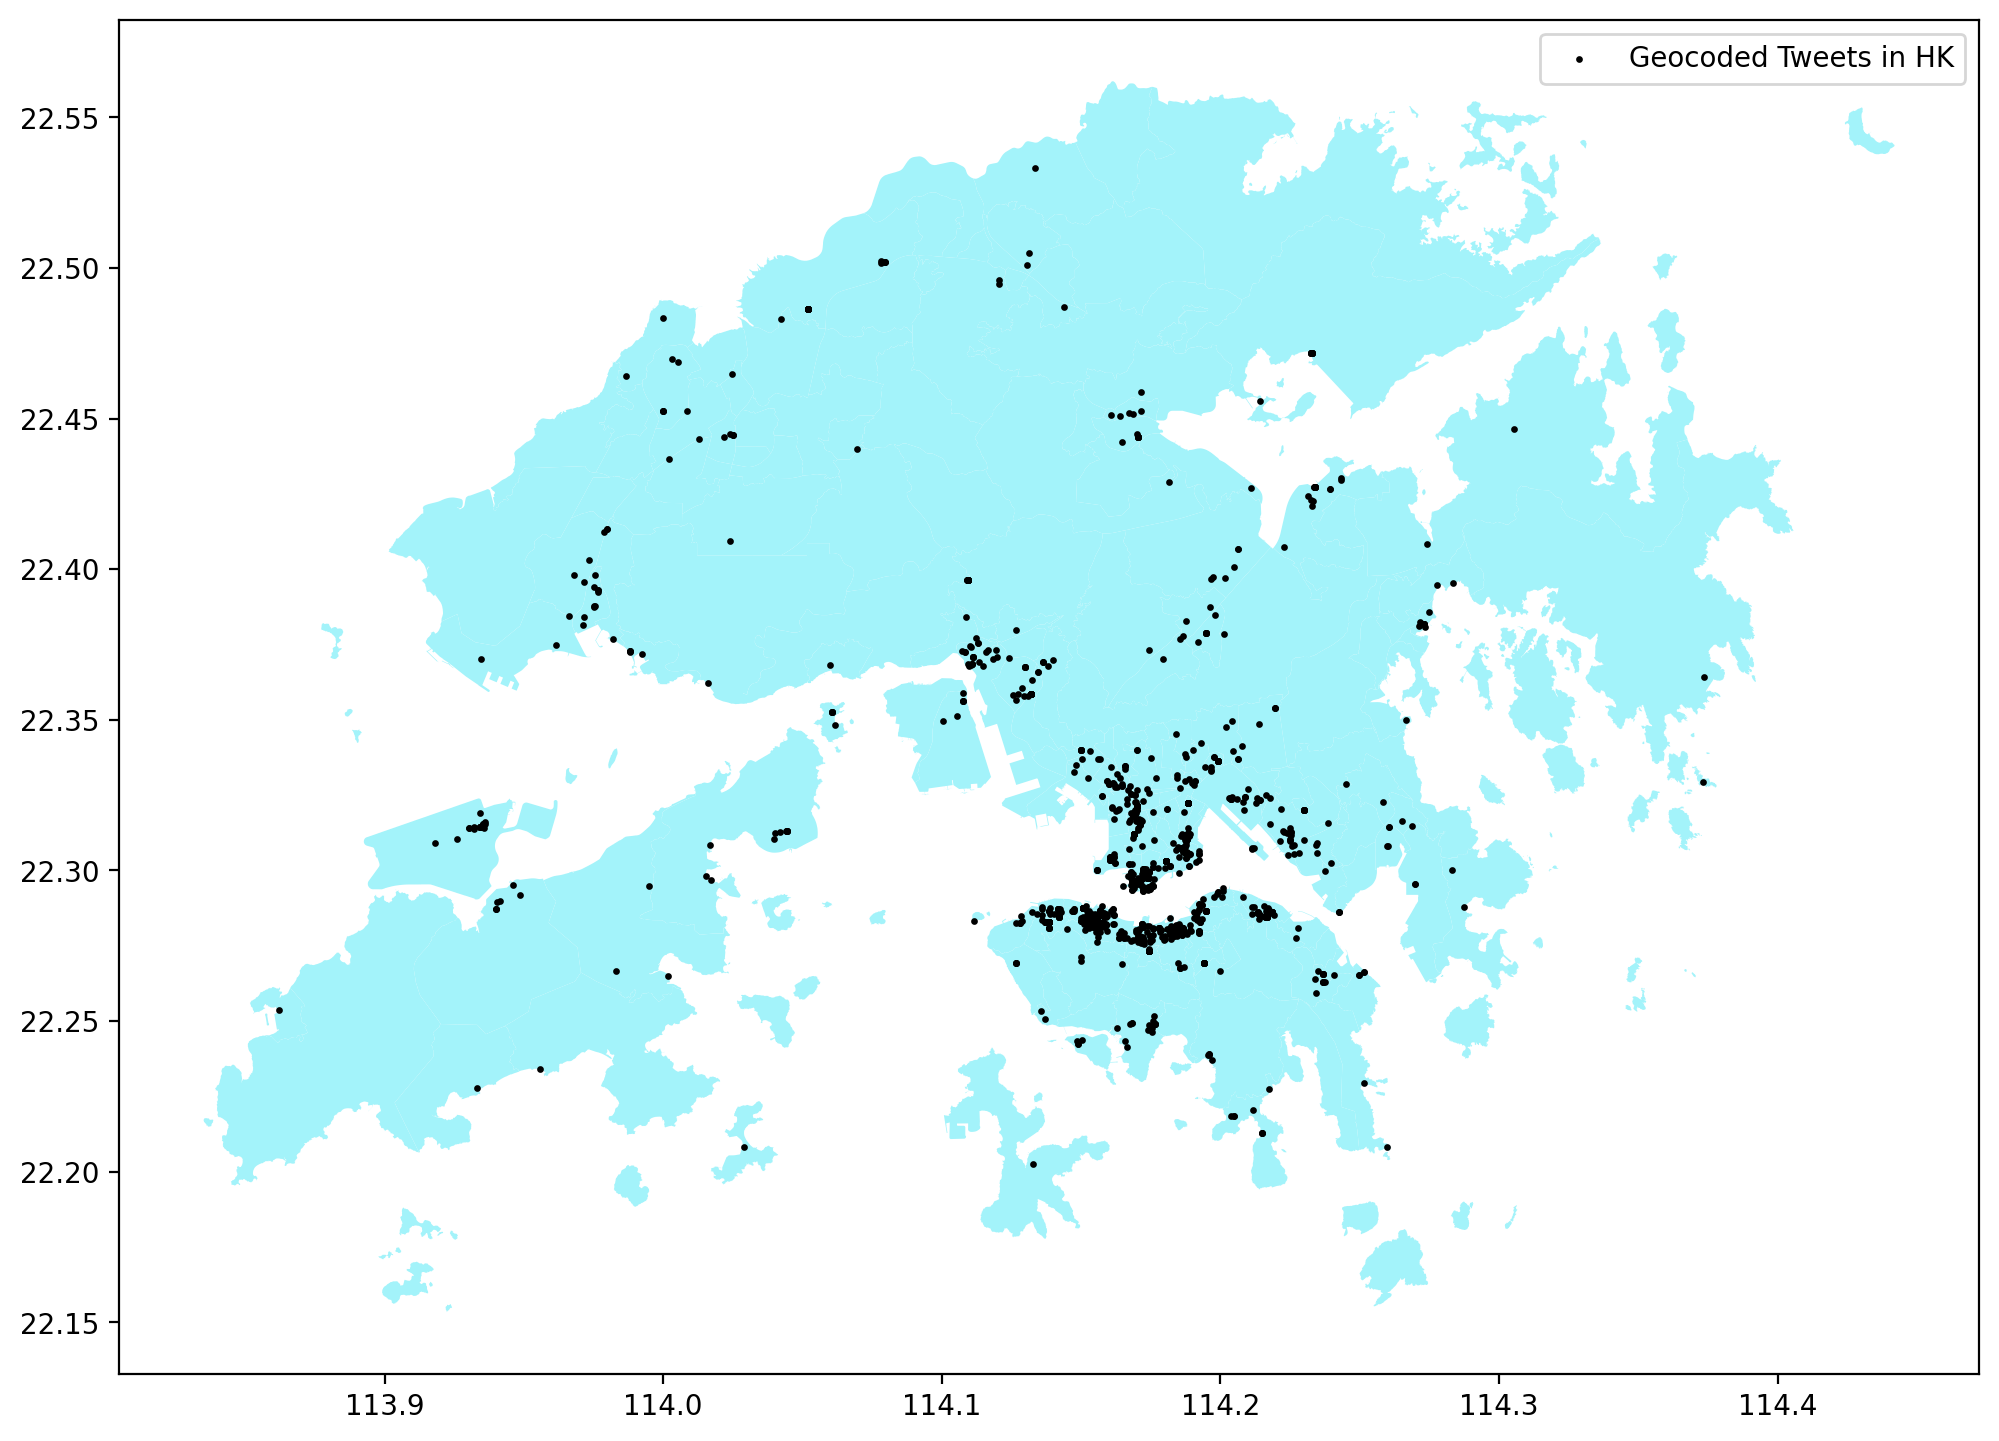

In [33]:
plot_shape(city_shapefile=hk_tpu, tweet_dataframe=combined_tweets_with_time)

## 3. Packages Needed to Install

Some packages are needed to install manually:

1. Spatial analysis: Geopandas. The installation process for geopandas on windows is quite complicated, especially with pip. Please check [this stackoverflow post](https://stackoverflow.com/questions/56958421/pip-install-geopandas-on-windows) for more information.
2. Text processing: [vader](https://github.com/cjhutto/vaderSentiment), [ekphrasis](https://github.com/cbaziotis/ekphrasis), [PaddleHub](https://github.com/PaddlePaddle/PaddleHub)